<a href="https://colab.research.google.com/github/HuangruiChu/MIMIC-III-Breast-Cancer-study/blob/main/MIMIC_Breast_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align='center' ><font size='5'>
BIS 638 (FA22): Clinical Database Management Systems and Ontologies Final Project
</font></div>

<div align='center' ><font size='6'>
Breast Cancer Analysis based on MIMIC III
</font></div>

<div align='center' ><font size='4'>
Group Name: Infinite Justice

Group Member：Huangrui Chu, Yaoqi Li, Laura Sun, Mingrui Wang

Yale Univserity School of Public Health
</font></div>


# **1. Introduction**

*This project for Yale Course BIS 638: Clinical Database Management Systems and Ontologies Final Project*

## 1.1 Background
- **请简介一下 breast cancer**

<br/>

## 1.2 Research Questions
- 放上我们的research question **需要后期再arrange 一下**
1.	Age distribution of breast cancer patients (when visiting hospitals, diagnosed, dead) V.S International organization’s recommendation for women's health check and breast cancer high-occurrence age. 
a.	Time from treatment to death, find the avg/median （**在考虑在第一部分要不要删了）
b.	Age distribution, survival ratio (survived V.S dead) （**我其实是把死亡率，性别比例等等分开来的）
2.	Breast cancer and its complication 
3.	What are the attributes that are most correlated to breast cancer? (Utilizing random forest to rank the feature importance based on Gini parameters)
4.	 Mortality 
a.	Visualize the distribution of the Top 3 variables for all patients in the breast cancer dataset. (Or establish ML (SVM, LR, XGBoost) models to predict in-hospital mortality using the Top 10 essential features if time is enough)
b.	What kind of previous and current services for the breast cancer patient? Do the hospital service's transformation and transfer time affect breast cancer patients' mortality? 
c. Find the correlation between mortality and prescriptions such as drug type, dose, and route. 
5.	Find the correlation between mortality and prescriptions such as drug type, dose, and route. 
<br/>

## 1.3 Data Sources

The data comes from [MIMIC-III](https://physionet.org/content/mimiciii/1.4/), which is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (including post-hospital discharge).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors: it is freely available to researchers worldwide; it encompasses a diverse and very large population of ICU patients; and it contains highly granular data, including vital signs, laboratory results, and medications.
  
  
  摘自 abstract 大家可以paraphrase 一下

<div  align="center"> 
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTeV6ahtZ6-POUjabTbHU973fbwmNAqleU5ag&usqp=CAU" width = "100" alt="img" />
</div>


  - To access MIMIC-III, our group have finished [CITI Training for Data or Specimens Only Research](https://www.citiprogram.org/verify/?wf27bcd4b-1305-43f1-a4f9-16549df886fa-51130798). The certifications are shown below.

<div  align="center"> 

<img src="https://raw.githubusercontent.com/HuangruiChu/MIMIC-III-Breast-Cancer-study/main/CITI_certification_Huangrui_Chu.png" width = "300" alt="img" />
<img src="https://raw.githubusercontent.com/HuangruiChu/MIMIC-III-Breast-Cancer-study/main/CITI_certification_Mingrui_Huang.png" width = "300" alt="img" />
<img src="https://raw.githubusercontent.com/HuangruiChu/MIMIC-III-Breast-Cancer-study/main/CITI_certification_Yaoqi_Li.jpg" width = "300" alt="img" />
<img src="https://raw.githubusercontent.com/HuangruiChu/MIMIC-III-Breast-Cancer-study/main/CITI_certification_Kuankuan_Sun.png" width = "300" alt="img" />
</div>

Data files have be downloaded and saved in google drive, and will be loaded into google colab. The data are for research study only and we would not upload them to github.

<br/>

## 1.4 Methods 
<br/>
<img src="https://mark.trademarkia.com/logo-images/epoint-sa/vertabelo-86225942.jpg" height = "50" alt="img" />
<img src="https://www.sqlite.org/images/sqlite370_banner.gif" height = "50" alt="img" />
<img src="https://miro.medium.com/max/776/1*Lad06lrjlU9UZgSTHUoyfA.png" height = "50" alt="img" />
<img src="https://www.ebi.ac.uk/ols/img/OLS_logo_2017.png" height = "50" alt="img" />

<br/>

#大概也要paraphrase 一下
- Use [Vertabelo Database Modeler](https://vertabelo.com/) to design an ER model, then generate a MySQL script.
- Use google colab to install SQLite, read in SQL script and create a database with MIMIC III data.
- Use [OLS](https://www.ebi.ac.uk/ols/index) as an ontology resource, link the disease terms in Disease Ontology to the patient data representation (icd9_code)





# **2. Database Construction** 

## 2.1 Coding Environment Preparation

- Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


- Require libraries

In [ ]:
import pandas as pd
import sqlite3
from sqlite3 import Error
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## 2.2 Data Resource

- The data files we will use include:
  - `PATIENTS`: Defines each SUBJECT_ID in the database, i.e. defines a single patient
  - `ADMISSIONS`: Define a patient’s hospital admission, HADM_ID
  - `DIAGNOSES_ICD`: Contains ICD diagnoses for patients, most notably ICD-9 diagnoses
  - `D_ICD_DIAGNOSES`: Definition table for ICD diagnoses
  - `ICUSTAYS`: Defines each ICUSTAY_ID in the database, i.e. defines a single ICU stay
  - `PRESCRIPTIONS`: Contains medication related order entries, i.e. prescriptions

- We Create an ER model with Vertabelo for our project

**我们自己也要做一个吗？做一个呗！**

  - The whole MIMIC Schema and Entity-Relationship (ER) Diagram can be seen via this [link](https://mit-lcp.github.io/mimic-schema-spy/)

- Write Python code with embedded SQL to create database, tables and query the tables


In [ ]:
""" create a database connection to a database that resides
    in the drive
"""
conn = None;

#conn = sqlite3.connect(':memory:')
#replace the following file path with your own
conn = sqlite3.connect('/content/gdrive/MyDrive/BIS638/2022/mimic_labdata.db')

cursor = conn.cursor()
#Doping tables if already exists.
cursor.execute("DROP TABLE IF EXISTS Patients")
cursor.execute("DROP TABLE IF EXISTS Admissions")
cursor.execute("DROP TABLE IF EXISTS Diagnoses_icd")
cursor.execute("DROP TABLE IF EXISTS D_icd_diagnoses")
#Creating tables
# The meaning of these variables can be seen here https://mit-lcp.github.io/mimic-schema-spy/tables/patients.html
sql ='''CREATE TABLE Patients (
  row_id int  NOT NULL,
  subject_id int  NOT NULL,
  gender varchar(5)  NOT NULL,
  dob datetime  NOT NULL,
  dod datetime  NOT NULL,
  dod_hosp datetime  NULL,
  dod_ssn datetime  NULL,
  expire_flag varchar(5)  NOT NULL,
  PRIMARY KEY (subject_id)
);'''
cursor.execute(sql)
sql ='''CREATE TABLE Admissions (
  row_id int  NOT NULL,
  subject_id int  NOT NULL,
  hadm_id int  NOT NULL,
  admittime datetime  NOT NULL,
  dischtime datetime  NOT NULL,
  deathtime datetime   NULL,
  admission_type varchar(50)  NOT NULL,
  admission_location varchar(50)  NOT NULL,
  discharge_location varchar(50)  NOT NULL,
  insurance varchar(255)  NOT NULL,
  language varchar(10)   NULL,
  religion varchar(50)   NULL,
  marital_status varchar(50)   NULL,
  ethnicity varchar(200)  NOT NULL,
  edregtime datetime   NULL,
  edouttime datetime   NULL,
  diagnosis varchar(300)  NOT NULL,
  hospital_expire_flag int  NOT NULL,
  has_chartevents_data int  NOT NULL,
  PRIMARY KEY (hadm_id),
  FOREIGN KEY (subject_id) REFERENCES Patients(subject_id)
);'''
cursor.execute(sql)
#insert code to create D_icd_diagnoses table
sql ='''CREATE TABLE D_icd_diagnoses (
      row_id int  NOT NULL,
      icd9_code varchar(10)	  NOT NULL,
      short_title varchar(50)  NOT NULL,
      long_title varchar(255)   NOT NULL,
      PRIMARY KEY (icd9_code)
  );'''
cursor.execute(sql)

#insert code to create Diagnoses_icd table
sql ='''CREATE TABLE Diagnoses_icd (
      row_id int  NOT NULL,
      subject_id	int NOT NULL,
      hadm_id	int NOT NULL,
      seq_num	int NULL,
      icd9_code	varchar(10) NULL,
      FOREIGN KEY (subject_id) REFERENCES patients(subject_id),
      FOREIGN KEY (hadm_id) REFERENCES admissions(hadm_id),
      FOREIGN KEY (icd9_code) REFERENCES d_icd_diagnoses(icd9_code)
  );'''
cursor.execute(sql)

print("Table(s) created successfully........")
conn.commit()

#load the data from the MIMIC DEMO URL
patients = pd.read_csv('/content/gdrive/MyDrive/BIS638/2022/PATIENTS.csv')
admissions = pd.read_csv('/content/gdrive/MyDrive/BIS638/2022/ADMISSIONS.csv')

#insert code to load D_ICD_DIAGNOSES.csv and DIAGNOSES_ICD.csv into the corresponding Pandas DataFrame objects
d_icd_diagnoses = pd.read_csv('/content/gdrive/MyDrive/BIS638/2022//D_ICD_DIAGNOSES.csv')
diagnoses_icd = pd.read_csv('/content/gdrive/MyDrive/BIS638/2022/DIAGNOSES_ICD.csv')



#write the data to a sqlite table
patients.to_sql('Patients', conn, if_exists='replace', index = False)
admissions.to_sql('Admissions', conn, if_exists='replace', index = False)

#insert code to write data to D_icd_diagnoses and Diagnoses_icd tables 
d_icd_diagnoses.to_sql('D_icd_diagnoses', conn, if_exists='replace', index = False)
diagnoses_icd.to_sql('Diagnoses_icd', conn, if_exists='replace', index = False)

#Commit your changes in the database
conn.commit()

Table(s) created successfully........


## 2.3 Breast Cancer Patients

We want to extract information that only contains breast cancer patients.

First, we need to know what `icd9_code` represents breat cancer.Therefore, we refer to the [National Libaray of Medicine](https://www.ncbi.nlm.nih.gov/books/NBK367629/table/sb201.t4/) to get the ICD-9-CM diagnosis codes for defining breast cancer.

In [ ]:
get_breast_cancer_titles='''SELECT icd9_code,short_title,long_title FROM D_icd_diagnoses 
WHERE icd9_code IN ("2330", "1740", "1741", "1742", "1743", "1744", "1745", "1746", "1748", "1749");'''
Breast_cancer_titles = pd.read_sql(get_breast_cancer_titles, conn)
display(Breast_cancer_titles)

,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,1740,Malig neo nipple,Malignant neoplasm of nipple and areola of fem...
1,1741,Mal neo breast-central,Malignant neoplasm of central portion of femal...
2,1742,Mal neo breast up-inner,Malignant neoplasm of upper-inner quadrant of ...
3,1743,Mal neo breast low-inner,Malignant neoplasm of lower-inner quadrant of ...
4,1744,Mal neo breast up-outer,Malignant neoplasm of upper-outer quadrant of ...
5,1745,Mal neo breast low-outer,Malignant neoplasm of lower-outer quadrant of ...
6,1746,Mal neo breast-axillary,Malignant neoplasm of axillary tail of female ...
7,1748,Malign neopl breast NEC,Malignant neoplasm of other specified sites of...
8,1749,Malign neopl breast NOS,"Malignant neoplasm of breast (female), unspeci..."
9,2330,Ca in situ breast,Carcinoma in situ of breast


Extract the breast cancer patients with all the relative information

In [ ]:
cursor.execute("DROP TABLE IF EXISTS Breast_cancer")
extract_breast_cancer_patient='''
CREATE TABLE IF NOT EXISTS Breast_cancer AS
  SELECT p.*,b.short_title, d.icd9_code
  FROM Patients p 
  inner join Diagnoses_icd d on d.subject_id=p.subject_id  
  inner join D_icd_diagnoses b on d.icd9_code=b.icd9_code 
  WHERE b.icd9_code IN ("2330", "1740", "1741", "1742", "1743", "1744", "1745", "1746", "1748", "1749")
  ORDER BY p.subject_id
  '''
cursor.execute(extract_breast_cancer_patient)

we notice that some date seem to be in the future. We think of it as the deidentification. Therefore, we can still make use of the data to get the age of the patientes at each time spot.

In [ ]:
sql='''SELECT COUNT(DISTINCT b.subject_id) AS breast_cancer_subject, COUNT(DISTINCT a.hadm_id) AS breast_cancer_admission 
  FROM Breast_cancer b
  inner join Admissions a on a.subject_id=b.subject_id  
  ;'''
breast_cancer_countdata = pd.read_sql(sql, conn)
display(breast_cancer_countdata)

,breast_cancer_subject,breast_cancer_admission
0,144,200


There are in total 144 patients in MIMIC3 database who had breast cancer with total admission of 200.

# 3. Exploratory Data Analysis



## 3.1 Gender propotion

We know that male rarely get breast cancers. Here we first want to have a brief idea of the gender propotion of breast cancer in MIMIC III.

With in the data we have 1 male patient and 143 female patient


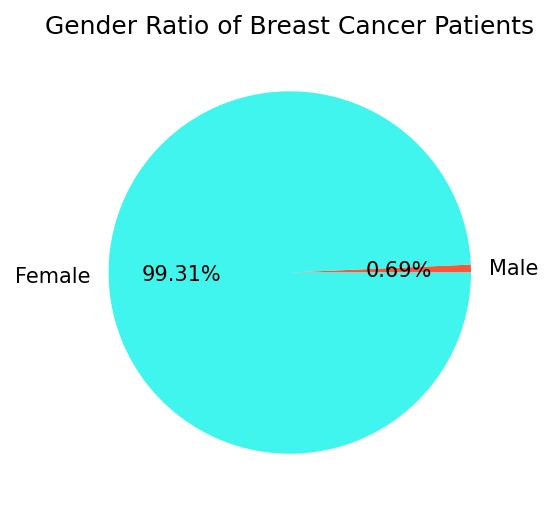

In [ ]:
sql_statement ='''SELECT distinct subject_id,gender
         FROM Breast_cancer'''
cursor.execute(sql_statement)
dbresult = cursor.fetchall()
gender_indicator = []
for r in dbresult:
  #get the gender information
  gender_indicator.append(r[1])

male = gender_indicator.count("M")
female = gender_indicator.count("F")
data=[male, female]
labels = ['Male', 'Female']
colors=["#FB5734", "#3FF5ED"]
name='Gender Ratio of Breast Cancer Patients'
print("With in the data we have {} male patient and {} female patient".format(male,female))
def plot_pie(data,labels,colors,name):
  plt.figure(dpi=150)
  plt.pie(data, labels = labels, colors=colors, autopct = '%1.2f%%')
  plt.title(name)
  plt.show()
plot_pie(data,labels,colors,name)


We notice that there is only 1 male out of 144 patients that is diagnosed with breast cancer. **与世界卫生组织的报告的数据相对比**

## 3.2 Age distribution 

We want to know the age distribution of breast cancer patients (when visiting hospitals, diagnosed, dead) V.S International organization’s recommendation for women health check and breast cancer high-occurrence age.


In [ ]:
get_death_age='''SELECT distinct subject_id, (dod-dob) as expire_age
FROM Breast_cancer
where expire_flag = 1'''
breast_cancer_death_agedata = pd.read_sql(get_death_age, conn)
get_diagnosis_age='''SELECT distinct b.subject_id, (a.admittime-b.dob) as diagnosis_age, JULIANDAY(a.dischtime) - JULIANDAY(a.admittime) as in_hospital_days
FROM Breast_cancer b
inner join Admissions a on a.subject_id == b.subject_id '''
breast_cancer_diagnosis_agedata = pd.read_sql(get_diagnosis_age, conn)
display(breast_cancer_diagnosis_agedata)

,SUBJECT_ID,diagnosis_age,in_hospital_days
0,2297,49,9.718056
1,2693,42,3.024306
2,2984,56,14.736111
3,2984,59,5.186806
4,2984,60,5.465278
...,...,...,...
195,96453,56,1.868750
196,99268,59,4.686806
197,99268,61,7.421528
198,99268,61,10.815278


We notice from below that the largest age of the peolpe who died is 300 which is curently impossible.

In [ ]:
breast_cancer_diagnosis_agedata["diagnosis_age"].describe()

count    200.000000
mean      61.965000
std       32.258749
min       25.000000
25%       48.000000
50%       56.000000
75%       67.000000
max      300.000000
Name: diagnosis_age, dtype: float64

In [ ]:
breast_cancer_diagnosis_agedata["in_hospital_days"].describe()

count    200.000000
mean       8.759226
std        9.196254
min        0.138889
25%        4.151736
50%        5.821528
75%       10.285937
max       85.744444
Name: in_hospital_days, dtype: float64

In [ ]:
breast_cancer_death_agedata['expire_age'].describe()

count     68.000000
mean      67.823529
std       42.948404
min       25.000000
25%       51.000000
50%       59.500000
75%       70.500000
max      301.000000
Name: expire_age, dtype: float64

Therefore, we filter out the data with the age less than 100 and then plot the histogram.

In [ ]:
def plot_histogram(data,name):
  plt.figure(dpi=100)
  plt.hist(data, bins = 12, color = 'steelblue', edgecolor = 'k')
  plt.title(name)
  plt.show()


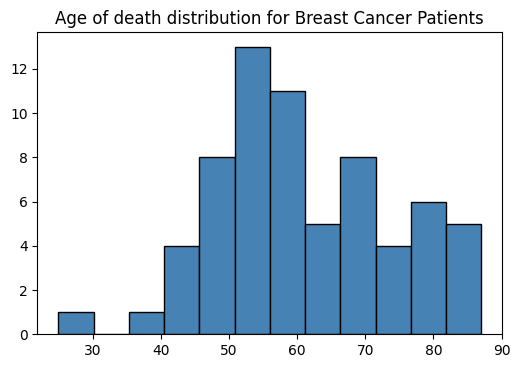

In [ ]:
death_ages=breast_cancer_death_agedata['expire_age']
death_ages=death_ages[death_ages<100]
data=death_ages
name='Age of death distribution for Breast Cancer Patients'
plot_histogram(data,name)

we can see that most women who is diagnosed with breast cancer are in age (????)

**与世界卫生组织的报告的数据相对比** 

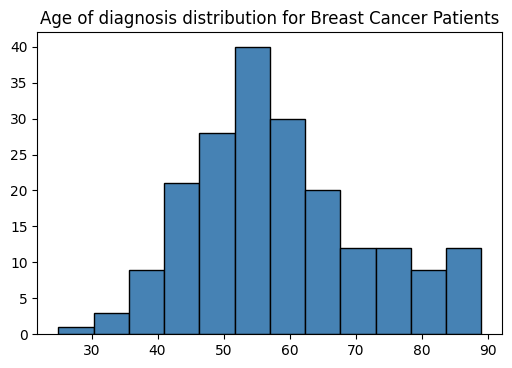

In [ ]:
diagnosis_ages=breast_cancer_diagnosis_agedata['diagnosis_age']
diagnosis_ages=diagnosis_ages[diagnosis_ages<100]
data=diagnosis_ages
name='Age of diagnosis distribution for Breast Cancer Patients'
plot_histogram(data,name)

we can see that most women who are diagnosed with breast cancer are in age (?????) **与世界卫生组织的报告的数据相对比**

Then, we want to know the average age of those who died. 

In [ ]:
np.average(death_ages)

60.75757575757576

**与世界卫生组织的报告的数据相对比, 为啥要看平均死亡年龄来着？** 

## 3.2 Time of treatment 

We want to know the time from treatment to death, find the avg/median

Time of treatment
**这里只是住院时间 可能死了 也可能活着出去了  所以我其实是没有明白为啥一定要做住院到死亡时间 原本提出这个思路只是因为教授说可以 研究住ICU时间和 是否死亡 这个能不能做regression model**

<Figure size 600x400 with 0 Axes>

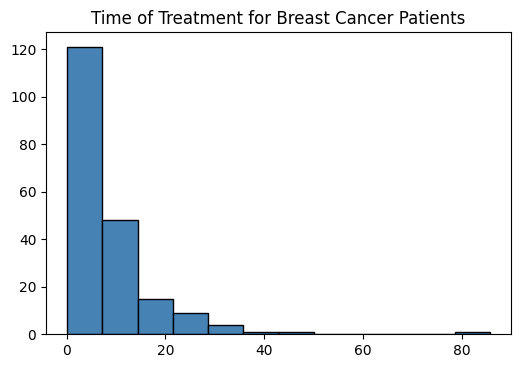

In [ ]:
plt.figure(dpi=100)
data=breast_cancer_diagnosis_agedata['in_hospital_days']
name='Time of Treatment for Breast Cancer Patients'
plot_histogram(data,name)

## 3.3 Survival ratio (survived V.S dead)

We want to learn about the survival ratio (survived V.S dead) of breast cancer.

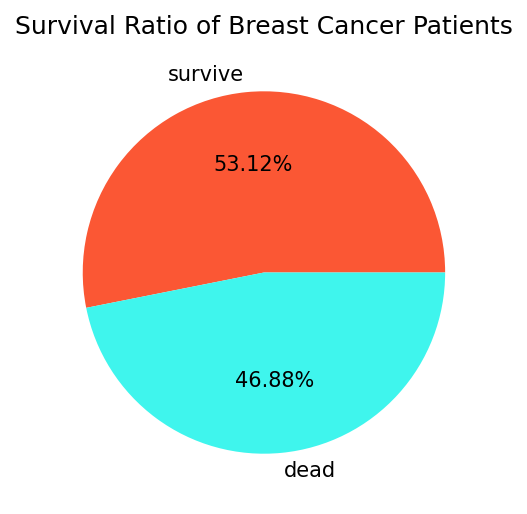

In [ ]:
sql_statement = "SELECT expire_flag FROM Breast_cancer"
cursor.execute(sql_statement)
dbresult = cursor.fetchall()
death_indicator = []
for r in dbresult:
  death_indicator.append(r[0])

# print(death_indicator)
survive = death_indicator.count(0)
death = death_indicator.count(1)
data=[survive, death]
labels = ['survive', 'dead']
colors=["#FB5734", "#3FF5ED"]
name='Survival Ratio of Breast Cancer Patients'
def plot_pie(data,labels,colors,name):
  plt.figure(dpi=150)
  plt.pie(data, labels = labels, colors=colors, autopct = '%1.2f%%')
  plt.title(name)
  plt.show()
plot_pie(data,labels,colors,name)

# 4. Ontology


**Breast cancer +cancer +drugs**

## 4.1 Retrieve DOID terms (and their synonyms) that have ICD9CM codes

The code below (that will be modified by students) iterates through each descendent term of heart disease to extract its DOID, synonyms (including labels), and ICD9 codes that are stored in the corresponding lists. 

In [ ]:
import requests
#  GET (using requests) all the ICD9 terms that are descendants of lung disease as the root
#DOID for lung disease
doid='DOID_1612' #DOID for Breast Cancer
url_base='https://www.ebi.ac.uk/ols/api/ontologies/doid/terms/'
url_terms=url_base+'http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252F'+doid+'/descendants?page=0&size=200'
icdlist = []
doidlist = []
synlist = []
terms={}

# get the JSON output containing all descendants of "heart diseaase"
r2 = requests.get(url = url_terms)
data2 = r2.json()
##insert your own code below to assign the names of the two keys represented by key1 and key2
key1='_embedded'
key2='terms' 

#a collection of terms extracted from the JSON object
terms=data2[key1][key2]

#retrieve DOID's, synonyms (including labels) and ICD9 codes (without dots) for each descendant term
for term in terms:
    # find the database for ICD9 codes
  label=term['label']
  iri=term['iri']
  lst=iri.split('_')
  obo_id='DOID:'+lst[1]
  db=''
  if 'database_cross_reference' in term['annotation']:
    for d2 in term['annotation']['database_cross_reference']:
      dblst=d2.split(':')
      db=dblst[0]
      code=dblst[1]
      if db=='ICD9CM':
        break
    if db=='ICD9CM':
        code=code.replace('.','')
        if 'has_exact_synonym' in term['annotation']:
          doidlist.append(obo_id)
          synlist.append(label)
          icdlist.append(code)
          for s in term['annotation']['has_exact_synonym']:
            doidlist.append(obo_id)
            synlist.append(s)
            icdlist.append(code)

print(f"Length of doidlist: {len(doidlist)}, length of synlist: {len(synlist)}, length of icdlist: {len(icdlist)} \n")  
print(doidlist)

Length of doidlist: 14, length of synlist: 14, length of icdlist: 14 

['DOID:11889', 'DOID:11889', 'DOID:11889', 'DOID:13972', 'DOID:13972', 'DOID:13799', 'DOID:13799', 'DOID:13799', 'DOID:1649', 'DOID:1649', 'DOID:1647', 'DOID:1647', 'DOID:1650', 'DOID:1650']


## 4.2 Create Table that maps DOID with ICD9 

First, we create an empty table. Then we feed the data extracted from [OLS](https://www.ebi.ac.uk/ols/ontologies/doid/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FDOID_1612) about Breast Cancer into this mapping table

In [ ]:
cursor.execute("DROP TABLE IF EXISTS DOID_ICD9_mappings")
#insert code to create DOID_ICD9_mappings table
sql ='''CREATE TABLE DOID_ICD9_mappings (
      doid varchar(10),
      synonym varchar(50),
      icd9_code	varchar(10) NULL,
      PRIMARY KEY (doid)
      FOREIGN KEY (icd9_code) REFERENCES d_icd_diagnoses(icd9_code)
  );'''
cursor.execute(sql)

synonyms = None
# load the data from the three lists into a data frame object "synonyms"
data = {'doid':doidlist,'synonym':synlist,'icd9_code':icdlist}
synonyms = pd.DataFrame(data)
# write the data to a sqlite table
synonyms.to_sql('DOID_ICD9_mappings', conn, if_exists='replace', index = False)
# Commit your changes in the database
conn.commit()

We want to see the synonym of the breast cancer.

In [ ]:
sql='''
CREATE TABLE IF NOT EXISTS Breast_cancer_syn AS
  SELECT distinct i.icd9_code, i.short_title,i.long_title,s.doid,s.synonym 
  from D_icd_diagnoses i
  left join DOID_ICD9_mappings s on s.icd9_code==i.icd9_code
  where i.icd9_code IN ("2330", "1740", "1741", "1742", "1743", "1744", "1745", "1746", "1748", "1749");
    '''
cursor.execute(sql)
sql='''
SELECT * from Breast_cancer_syn
'''
syn = pd.read_sql(sql, conn)
pd.set_option('display.max_rows', 100)
display (syn)

,ICD9_CODE,SHORT_TITLE,LONG_TITLE,doid,synonym
0,1740,Malig neo nipple,Malignant neoplasm of nipple and areola of fem...,DOID:11889,female breast nipple and areola cancer
1,1740,Malig neo nipple,Malignant neoplasm of nipple and areola of fem...,DOID:11889,malignant neoplasm of nipple and areola of fem...
2,1740,Malig neo nipple,Malignant neoplasm of nipple and areola of fem...,DOID:11889,malignant neoplasm of nipple or areola of fema...
3,1741,Mal neo breast-central,Malignant neoplasm of central portion of femal...,DOID:13799,female breast central part cancer
4,1741,Mal neo breast-central,Malignant neoplasm of central portion of femal...,DOID:13799,malignant neoplasm of central part of female b...
5,1741,Mal neo breast-central,Malignant neoplasm of central portion of femal...,DOID:13799,malignant neoplasm of central portion of femal...
6,1742,Mal neo breast up-inner,Malignant neoplasm of upper-inner quadrant of ...,DOID:1647,female breast upper-inner quadrant cancer
7,1742,Mal neo breast up-inner,Malignant neoplasm of upper-inner quadrant of ...,DOID:1647,malignant neoplasm of upper-inner quadrant of ...
8,1743,Mal neo breast low-inner,Malignant neoplasm of lower-inner quadrant of ...,DOID:1649,female breast lower-inner quadrant cancer
9,1743,Mal neo breast low-inner,Malignant neoplasm of lower-inner quadrant of ...,DOID:1649,malignant neoplasm of lower-inner quadrant of ...


We can see from above that for ICD9 1744,1748,1749,2330, we do not have corresponding DOID and synonym


# 5. Feature Selection

In [ ]:
#Doping tables if already exists.
cursor.execute("DROP TABLE IF EXISTS ICUSTAYS")
cursor.execute("DROP TABLE IF EXISTS Labevents")

#Creating tables
#insert code to create ICUSTAYS table
sql ='''CREATE TABLE ICUSTAYS (
      row_id int  NOT NULL,
      subject_id	int NOT NULL,
      hadm_id	int NOT NULL,
      icustay_id	int NOT NULL,
      dbsource varchar(20),
      first_careunit varchar(20),
      last_careunit varchar(20),
      first_wardid smallint,
      last_wardid smallint,
      intime timestamp,
      outtime timestamp,
      los float8,
      FOREIGN KEY (subject_id) REFERENCES patients(subject_id),
      FOREIGN KEY (hadm_id) REFERENCES admissions(hadm_id)
  );'''
cursor.execute(sql)

#insert code to create Labevents table
sql ='''CREATE TABLE Labevents (
      row_id int  NOT NULL,
      subject_id	int NOT NULL,
      hadm_id	int NOT NULL,
      itemid	int NULL,
      charttime timestamp,
      value varchar(200),
      valuenum float8,
      valueuom varchar(20),
      flag varchar(20),
      FOREIGN KEY (subject_id) REFERENCES patients(subject_id),
      FOREIGN KEY (hadm_id) REFERENCES admissions(hadm_id)
  );'''
cursor.execute(sql)
print("Table(s) created successfully........")
conn.commit()

#insert code to load ICUSTAYS.csv and Labevents into the corresponding Pandas DataFrame objects
ICUSTAYS = pd.read_csv('/content/gdrive/MyDrive/BIS638/2022/ICUSTAYS.csv')
Labevents = pd.read_csv('/content/gdrive/MyDrive/BIS638/2022/LABEVENTS.csv')

#insert code to write data to ICUSTAYS and Labevents tables
ICUSTAYS.to_sql('ICUSTAYS', conn, if_exists='replace', index = False)
Labevents.to_sql('Labevents', conn, if_exists='replace', index = False)

#Commit your changes in the database
conn.commit()

Table(s) created successfully........


Extract the patients with all the Demographic Information：age, gender

In [ ]:
cursor.execute("DROP TABLE IF EXISTS Dem_info")
Dem_info='''
CREATE TABLE Dem_info AS
  SELECT a.subject_id, hadm_id, 
  (a.admittime-p.dob) 
  AS diagnosis_age,
  insurance,
  marital_status,
  religion,
  ethnicity
  FROM admissions a
  INNER JOIN patients p
  ON a.subject_id = p.subject_id
  '''
cursor.execute(Dem_info)
print("Table(s) created successfully........")
conn.commit()

Table(s) created successfully........


Extract the patients with all the ICU surgery

In [ ]:
cursor.execute("DROP TABLE IF EXISTS ICU_sur")
ICU_sur='''
CREATE TABLE ICU_sur AS
  SELECT hadm_id, 
  sum(los) AS total_icu_time 
  FROM ICUSTAYS
  GROUP BY hadm_id
  '''
cursor.execute(ICU_sur)
print("Table(s) created successfully........")
conn.commit()

Table(s) created successfully........


Extract the patients with all the Lab data

In [ ]:
cursor.execute("DROP TABLE IF EXISTS Lab")
Lab='''
CREATE TABLE Lab AS
  SELECT o.hadm_id, AVG_Urea_nitrogen, AVG_platelet, AVG_potassium, AVG_sodium, AVG_creatinine, AVG_leukocytes, AVG_sugar, AVG_albumin
  FROM
  (SELECT distinct hadm_id
  FROM labevents) o
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_Urea_nitrogen
  FROM labevents
  WHERE itemid = 51066
  GROUP BY hadm_id) a on o.hadm_id=a.hadm_id
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_platelet
  FROM labevents
  WHERE itemid = 51265
  GROUP BY hadm_id) b on o.hadm_id=b.hadm_id
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_hematocrito
  FROM labevents
  WHERE itemid = 51221
  GROUP BY hadm_id) c on o.hadm_id=c.hadm_id  
  left join   
  (SELECT hadm_id,
  avg(valuenum) AS AVG_potassium
  FROM labevents
  WHERE itemid = 50971
  GROUP BY hadm_id) d on o.hadm_id=d.hadm_id  
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_sodium
  FROM labevents
  WHERE itemid = 50983
  GROUP BY hadm_id) e on o.hadm_id=e.hadm_id
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_creatinine
  FROM labevents
  WHERE itemid = 50912
  GROUP BY hadm_id) f on o.hadm_id=f.hadm_id
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_leukocytes
  FROM labevents
  WHERE itemid = 51301
  GROUP BY hadm_id) g on o.hadm_id=g.hadm_id     
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_sugar
  FROM labevents
  WHERE itemid in (50809,50931)
  GROUP BY hadm_id) h on o.hadm_id=h.hadm_id
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_albumin
  FROM labevents
  WHERE itemid = 50862
  GROUP BY hadm_id) i on o.hadm_id=i.hadm_id
  where o.hadm_id is not null        
  '''
cursor.execute(Lab)
print("Table(s) created successfully........")
conn.commit()

Table(s) created successfully........


In [ ]:
cursor.execute("DROP TABLE IF EXISTS data_summary")
data_summary='''
CREATE TABLE data_summary AS
  SELECT *
  FROM Lab a
  inner join 
  Dem_info b on a.hadm_id=b.hadm_id
  inner join 
  ICU_sur c on a.hadm_id=c.hadm_id
  ;'''
cursor.execute(data_summary)
print("Table(s) created successfully........")
conn.commit()

Table(s) created successfully........


In [ ]:
cursor.execute("DROP TABLE IF EXISTS wide_summary")
wide_summary='''
CREATE TABLE IF NOT EXISTS wide_summary AS
  SELECT *,
  case when subject_id in (select subject_id from Breast_cancer) then 1
  else 0
  end as breast_outcome
  FROM data_summary
  '''
cursor.execute(wide_summary)

In [ ]:
sql='''
  SELECT  *
  FROM
  wide_summary
  ;'''
data = pd.read_sql(sql, conn)
display(data)

,hadm_id,AVG_Urea_nitrogen,AVG_platelet,AVG_potassium,AVG_sodium,AVG_creatinine,AVG_leukocytes,AVG_sugar,AVG_albumin,SUBJECT_ID,HADM_ID:1,diagnosis_age,INSURANCE,MARITAL_STATUS,RELIGION,ETHNICITY,HADM_ID:2,total_icu_time,breast_outcome
0,145834.0,NaN,210.866667,4.105263,137.555556,1.826667,12.533333,154.727273,1.800,3,145834,76,Medicare,MARRIED,CATHOLIC,WHITE,145834,6.0646,0
1,163353.0,NaN,153.500000,NaN,NaN,NaN,11.050000,NaN,NaN,2,163353,0,Private,None,NOT SPECIFIED,ASIAN,163353,0.0918,0
2,185777.0,NaN,286.428571,3.537500,137.750000,0.450000,9.442857,226.750000,2.800,4,185777,48,Private,SINGLE,PROTESTANT QUAKER,WHITE,185777,1.6785,0
3,178980.0,NaN,309.000000,NaN,NaN,NaN,13.900000,NaN,NaN,5,178980,0,Private,None,BUDDHIST,ASIAN,178980,0.0844,0
4,107064.0,NaN,247.947368,4.911765,134.411765,3.741176,13.589474,124.772727,2.875,6,107064,66,Medicare,MARRIED,NOT SPECIFIED,WHITE,107064,3.6729,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57154,109836.0,NaN,226.000000,3.550000,140.000000,0.650000,5.550000,169.500000,NaN,98759,109836,69,Private,WIDOWED,CATHOLIC,WHITE,109836,1.6425,0
57155,115549.0,NaN,382.000000,4.075000,138.000000,0.850000,12.266667,92.500000,NaN,98939,115549,22,Government,SINGLE,NOT SPECIFIED,WHITE,115549,1.8588,0
57156,144680.0,NaN,179.500000,4.100000,136.500000,0.900000,13.400000,107.000000,NaN,98883,144680,24,Private,SINGLE,UNOBTAINABLE,WHITE,144680,1.2967,0
57157,175386.0,NaN,210.500000,4.033333,141.666667,0.566667,5.450000,125.333333,NaN,98759,175386,69,Private,WIDOWED,CATHOLIC,WHITE,175386,1.2688,0


Check NAs

In [ ]:
data.isnull().sum()

hadm_id                  0
AVG_Urea_nitrogen    57145
AVG_platelet          1040
AVG_potassium         5126
AVG_sodium            5138
AVG_creatinine        7011
AVG_leukocytes        1024
AVG_sugar             7356
AVG_albumin          26385
SUBJECT_ID               0
HADM_ID:1                0
diagnosis_age            0
INSURANCE                0
MARITAL_STATUS        9750
RELIGION               454
ETHNICITY                0
HADM_ID:2                0
total_icu_time          10
breast_outcome           0
dtype: int64

After going though the Nan summary, we can find the columns (AVG_Urea_nitrogen, AVG_creatinine, AVG_sugar, AVG_albumin, MARITAL_STATUS) have more than 10% missing values. Based on this fact, I will take out these columns.

In [ ]:
columns = ['AVG_Urea_nitrogen','AVG_creatinine','AVG_sugar','AVG_albumin','MARITAL_STATUS','SUBJECT_ID','HADM_ID:1','HADM_ID:2','hadm_id']
data = data.drop(columns, axis=1)
data

,AVG_platelet,AVG_potassium,AVG_sodium,AVG_leukocytes,diagnosis_age,INSURANCE,RELIGION,ETHNICITY,total_icu_time,breast_outcome
0,210.866667,4.105263,137.555556,12.533333,76,Medicare,CATHOLIC,WHITE,6.0646,0
1,153.500000,NaN,NaN,11.050000,0,Private,NOT SPECIFIED,ASIAN,0.0918,0
2,286.428571,3.537500,137.750000,9.442857,48,Private,PROTESTANT QUAKER,WHITE,1.6785,0
3,309.000000,NaN,NaN,13.900000,0,Private,BUDDHIST,ASIAN,0.0844,0
4,247.947368,4.911765,134.411765,13.589474,66,Medicare,NOT SPECIFIED,WHITE,3.6729,0
...,...,...,...,...,...,...,...,...,...,...
57154,226.000000,3.550000,140.000000,5.550000,69,Private,CATHOLIC,WHITE,1.6425,0
57155,382.000000,4.075000,138.000000,12.266667,22,Government,NOT SPECIFIED,WHITE,1.8588,0
57156,179.500000,4.100000,136.500000,13.400000,24,Private,UNOBTAINABLE,WHITE,1.2967,0
57157,210.500000,4.033333,141.666667,5.450000,69,Private,CATHOLIC,WHITE,1.2688,0


Let's replace with the NaN valus with mean value

In [ ]:
data = data.fillna(data.mean())
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


,AVG_platelet,AVG_potassium,AVG_sodium,AVG_leukocytes,diagnosis_age,INSURANCE,RELIGION,ETHNICITY,total_icu_time,breast_outcome
0,210.866667,4.105263,137.555556,12.533333,76,Medicare,CATHOLIC,WHITE,6.0646,0
1,153.500000,4.163596,138.736050,11.050000,0,Private,NOT SPECIFIED,ASIAN,0.0918,0
2,286.428571,3.537500,137.750000,9.442857,48,Private,PROTESTANT QUAKER,WHITE,1.6785,0
3,309.000000,4.163596,138.736050,13.900000,0,Private,BUDDHIST,ASIAN,0.0844,0
4,247.947368,4.911765,134.411765,13.589474,66,Medicare,NOT SPECIFIED,WHITE,3.6729,0
...,...,...,...,...,...,...,...,...,...,...
57154,226.000000,3.550000,140.000000,5.550000,69,Private,CATHOLIC,WHITE,1.6425,0
57155,382.000000,4.075000,138.000000,12.266667,22,Government,NOT SPECIFIED,WHITE,1.8588,0
57156,179.500000,4.100000,136.500000,13.400000,24,Private,UNOBTAINABLE,WHITE,1.2967,0
57157,210.500000,4.033333,141.666667,5.450000,69,Private,CATHOLIC,WHITE,1.2688,0


Transform categorical variables into dummy variables

In [ ]:
data = pd.get_dummies(data)
data

,AVG_platelet,AVG_potassium,AVG_sodium,AVG_leukocytes,diagnosis_age,total_icu_time,breast_outcome,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,...,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN
0,210.866667,4.105263,137.555556,12.533333,76,6.0646,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,153.500000,4.163596,138.736050,11.050000,0,0.0918,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,286.428571,3.537500,137.750000,9.442857,48,1.6785,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,309.000000,4.163596,138.736050,13.900000,0,0.0844,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,247.947368,4.911765,134.411765,13.589474,66,3.6729,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57154,226.000000,3.550000,140.000000,5.550000,69,1.6425,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
57155,382.000000,4.075000,138.000000,12.266667,22,1.8588,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
57156,179.500000,4.100000,136.500000,13.400000,24,1.2967,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
57157,210.500000,4.033333,141.666667,5.450000,69,1.2688,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Train test spliting

In [ ]:
target = 'breast_outcome'
X = data.drop(target, axis=1)
y = data[target]

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.1)

Random Forest Training

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=0)

**我有个建议 下面这张图 能不能像620的HW2 那样 只显示 top 5 这种 比较有影响力的factors呢**

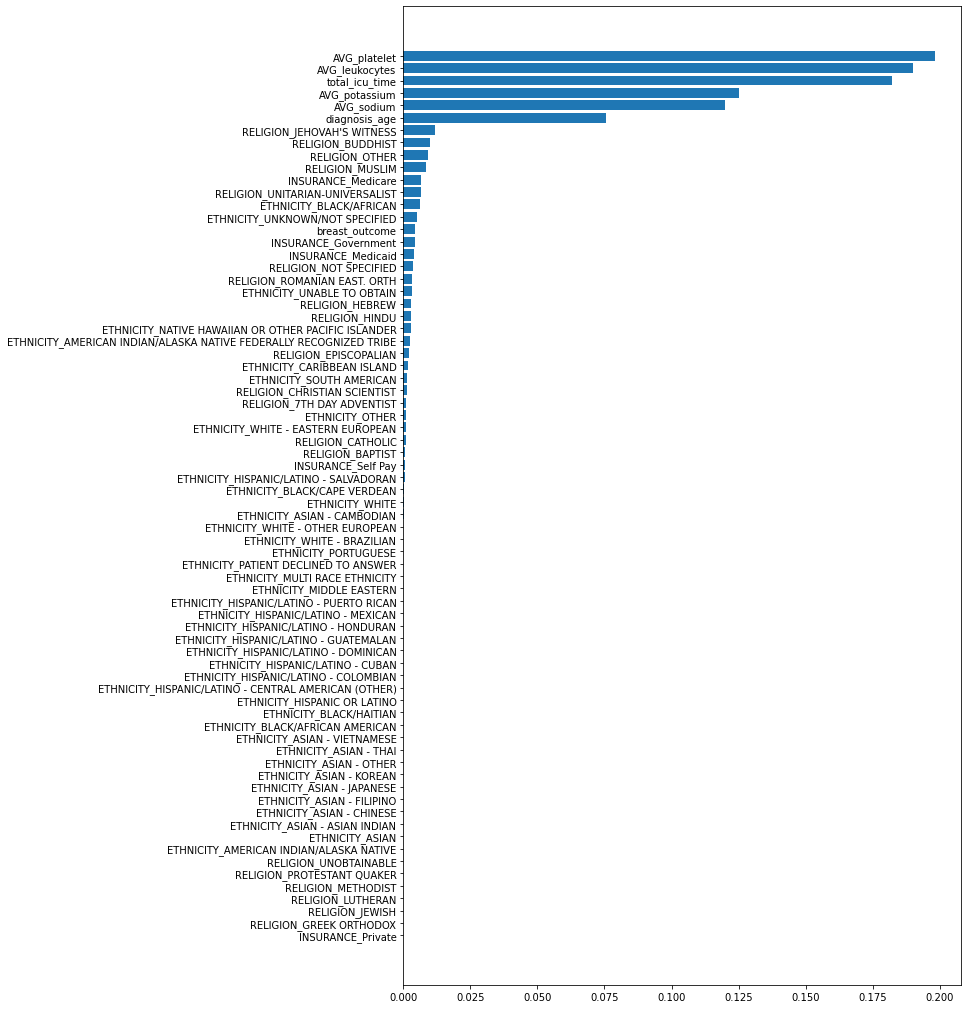

In [ ]:
features = data.columns
plt.figure(dpi=150)
plt.figure(figsize=(10,18))
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

So from the above diagram, we can conclude that the most important features are AVG_leukocytes, AVG_platelet, total_icu_time, AVG_sodium, AVG_potassium and diagnosis_age.

In [ ]:
x = features.tolist()
x

['AVG_platelet',
 'AVG_potassium',
 'AVG_sodium',
 'AVG_leukocytes',
 'diagnosis_age',
 'total_icu_time',
 'breast_outcome',
 'INSURANCE_Government',
 'INSURANCE_Medicaid',
 'INSURANCE_Medicare',
 'INSURANCE_Private',
 'INSURANCE_Self Pay',
 'RELIGION_7TH DAY ADVENTIST',
 'RELIGION_BAPTIST',
 'RELIGION_BUDDHIST',
 'RELIGION_CATHOLIC',
 'RELIGION_CHRISTIAN SCIENTIST',
 'RELIGION_EPISCOPALIAN',
 'RELIGION_GREEK ORTHODOX',
 'RELIGION_HEBREW',
 'RELIGION_HINDU',
 "RELIGION_JEHOVAH'S WITNESS",
 'RELIGION_JEWISH',
 'RELIGION_LUTHERAN',
 'RELIGION_METHODIST',
 'RELIGION_MUSLIM',
 'RELIGION_NOT SPECIFIED',
 'RELIGION_OTHER',
 'RELIGION_PROTESTANT QUAKER',
 'RELIGION_ROMANIAN EAST. ORTH',
 'RELIGION_UNITARIAN-UNIVERSALIST',
 'RELIGION_UNOBTAINABLE',
 'ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE',
 'ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
 'ETHNICITY_ASIAN',
 'ETHNICITY_ASIAN - ASIAN INDIAN',
 'ETHNICITY_ASIAN - CAMBODIAN',
 'ETHNICITY_ASIAN - CHINESE',
 'ETHNICITY_ASIAN

# 6. Logistic Regression

It is significant to train a model to predict whether a person can get breast cancer so that we can prevent the disease easier. 

Text(0.5, 257.44, 'Predicted label')

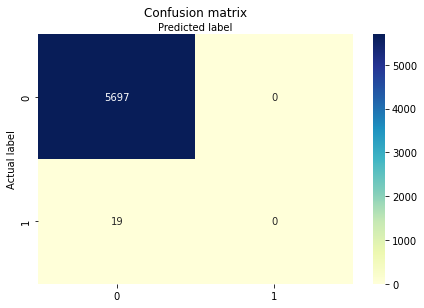

In [ ]:
X2=data[['AVG_leukocytes', 'AVG_platelet','total_icu_time', 'AVG_sodium', 'AVG_potassium', 'diagnosis_age']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.3)
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=16)
logreg.fit(X2_train, y2_train)
y2_pred = logreg.predict(X2_test)


from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y2_test, y2_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(cnf_matrix):
  class_names=[0,1] # name  of classes
  plt.figure(dpi=150)
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  
plot_confusion_matrix(cnf_matrix)
#Text(0.5,257.44,'Predicted label');

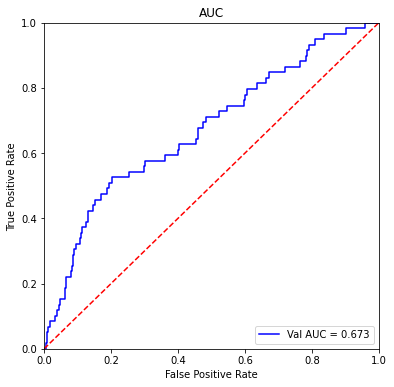

In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pylab as plt
pred = logreg.predict_proba(X2_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y2_test, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(dpi=150)
plt.figure(figsize=(6,6))
plt.title('AUC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Autoencoder

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 1].index
train_data = X_train.loc[train_index]
# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(X_train.copy())
x_test_scaled = min_max_scaler.transform(X_test.copy())

In [ ]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(256, activation='relu'),
      Dropout(0.3),
      Dense(32, activation='relu'),
      Dropout(0.3),
      Dense(16, activation='relu'),
      Dropout(0.3),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.3),
      Dense(32, activation='relu'),
      Dropout(0.3),
      Dense(256, activation='relu'),
      Dropout(0.3),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
101/101 [==============================] - 4s 34ms/step - loss: 0.0361 - mse: 0.0620 - val_loss: 0.0137 - val_mse: 0.0287
Epoch 2/20
101/101 [==============================] - 4s 40ms/step - loss: 0.0147 - mse: 0.0302 - val_loss: 0.0131 - val_mse: 0.0273
Epoch 3/20
101/101 [==============================] - 4s 37ms/step - loss: 0.0136 - mse: 0.0283 - val_loss: 0.0130 - val_mse: 0.0266
Epoch 4/20
101/101 [==============================] - 4s 36ms/step - loss: 0.0124 - mse: 0.0259 - val_loss: 0.0102 - val_mse: 0.0215
Epoch 5/20
101/101 [==============================] - 4s 40ms/step - loss: 0.0103 - mse: 0.0215 - val_loss: 0.0084 - val_mse: 0.0178
Epoch 6/20
101/101 [==============================] - 4s 35ms/step - loss: 0.0091 - mse: 0.0189 - val_loss: 0.0075 - val_mse: 0.0160
Epoch 7/20
101/101 [==============================] - 3s 33ms/step - loss: 0.0084 - mse: 0.0176 - val_loss: 0.0069 - val_mse: 0.0147
Epoch 8/20
101/101 [==============================] - 4s 41ms/step - 

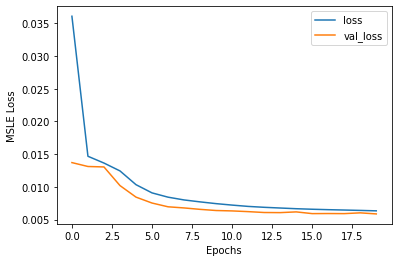

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)
# 0.944

1608/1608 [==============================] - 3s 2ms/step
Threshold: 0.010839623921291147
179/179 [==============================] - 0s 2ms/step


0.19384184744576627

**如果是比较神经网络与RF的话，是不是我们也做一个confusion matrix 比较好呢？**

# End the connection at the end of the document

In [ ]:
if conn:
  conn.close()

# 5. Reference & Acknowlegement

- Johnson, A., Pollard, T., & Mark, R. (2016). MIMIC-III Clinical Database (version 1.4). PhysioNet. https://doi.org/10.13026/C2XW26.

- Johnson, A. E. W., Pollard, T. J., Shen, L., Lehman, L. H., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Celi, L. A., & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. Scientific Data, 3, 160035.

- Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

- https://github.com/yijunyang/database/blob/main/MIMIC3_Project.ipynb

- Thanks to instructors Kei-Hoi Cheung, Ph.D. (Kei.cheung@yale.edu) and Ronald "George" Hauser, M.D. (ronald.hauser@yale.edu) for providing this informative course. Also, thanks to our teaching fellow Han Yu (han.yu@yale.edu) for providing advices on this project.
